# AWS SageMaker Dog Breed Classification Project

This notebook serves as a comprehensive guide to completing the project focused on using AWS SageMaker to build an image classification model capable of identifying different breeds of dogs. The project aims to provide clear instructions and explanations to ensure a successful implementation while meeting the project's requirements.

The dataset used in this project is specifically designed for dog breed classification, encompassing images of various dog breeds. The dataset can be found at a specified location.

The primary objective of this project is to develop an image classification model capable of accurately identifying different dog breeds. To achieve this, we will adopt a transfer learning approach, starting with a pre-trained Resnet50 model from the PyTorch vision library. By fine-tuning the last fully connected layer and incorporating our own layers, we will leverage the pre-trained model's learned features and tailor it to our specific use case.

Hyperparameter tuning will be employed to identify the optimal parameters for the classification task, ensuring the model's performance is maximized.

To ensure the model's robustness and debug any potential issues, we will incorporate profiling and debugging techniques. This will involve the integration of hooks during the training and testing phases.

Finally, the trained model will be deployed, and its performance will be evaluated on a set of test images containing various dog breeds to validate its accuracy and efficacy in real-world scenarios.

Throughout the notebook, you will find TODO tasks that need to be completed to finalize the project successfully. These tasks will guide you through the various stages of the project, including data preprocessing, model development, hyperparameter tuning, debugging, and model deployment. Clear explanations and documentation will be provided to make the project informative and professional.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys


role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Role: {role}')
print(f'S3 bucket : {bucket}')

[2023-07-25 15:32:44.454 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Role: arn:aws:iam::406658208551:role/service-role/AmazonSageMaker-ExecutionRole-20230410T132935
S3 bucket : sagemaker-us-east-1-406658208551


## Dataset

The dataset used in this project consists of 133 different dog breeds and is divided into three subsets: train, test, and validation. Each subset contains a diverse set of images representing each breed. The train subset is the largest, and it will be utilized to train the model to recognize distinctive features that distinguish various dog breeds. The objective is to enable the model to learn the patterns and characteristics unique to each breed during the training phase.

Once the training is complete, we will evaluate the model's performance using the test and validation subsets. The test subset serves as an independent dataset to assess how well the model generalizes to new, unseen images of dogs from the same breeds. On the other hand, the validation subset is used to fine-tune the model and adjust hyperparameters to avoid overfitting.

During training, the model learns to extract relevant features from the input images, gradually improving its ability to differentiate between different dog breeds. After training, we will put the model to the test using the test subset to see how accurately it can classify unseen images.

By dividing the dataset into separate subsets for training, testing, and validation, we ensure that the model's performance is reliable and capable of accurately identifying dog breeds in real-world scenarios. The ultimate goal is to create a robust and accurate model that can correctly identify dog breeds, even when presented with images it has never seen before.

In [5]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null
!rm dogImages.zip

--2023-06-18 16:56:57--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  27.0MB/s    in 30s     

2023-06-18 16:57:28 (35.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [6]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='dogImages')
print(inputs)

s3://sagemaker-us-east-1-406658208551/dogImages


s3://sagemaker-us-east-1-406658208551/dogImages

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs
estimator = PyTorch(entry_point = 'hpo.py',
                    base_job_name = 'dog-breed-class',
                    role = role,
                    instance_count = 1,
                    instance_type = 'ml.p3.2xlarge', 
                    py_version = 'py36',
                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs = 1,
                            max_parallel_jobs = 1,
                            objective_type = objective_type)

In [9]:
# TODO: Fit your HP Tuner
# Fit the hyperparameter tuner
tuner.fit({'train': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................!


In [12]:
# TODO: Get the best estimators and the best HPs

# Get the best estimator and hyperparameters
best_estimator = tuner.describe()['BestTrainingJob']['TrainingJobArn']

#Get the hyperparameters of the best trained model
best_hyperparameters = tuner.describe()['BestTrainingJob']['TunedHyperParameters']
value = best_hyperparameters['batch_size'].strip().replace('"', '')
best_hyperparameters['batch_size'] = int(value)
print('Best hyperparameters:')
for hp_name, hp_value in best_hyperparameters.items():
    print(f'{hp_name}: {hp_value}')

Best hyperparameters:
batch_size: 32
epochs: 5
lr: 0.0013928563495246822


In [11]:
tuner.best_estimator().hyperparameters()


2023-06-18 17:21:18 Starting - Preparing the instances for training
2023-06-18 17:21:18 Downloading - Downloading input data
2023-06-18 17:21:18 Training - Training image download completed. Training in progress.
2023-06-18 17:21:18 Uploading - Uploading generated training model
2023-06-18 17:21:18 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '5',
 'lr': '0.0013928563495246822',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-class-2023-06-18-17-12-36-411"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-406658208551/dog-breed-class-2023-06-18-17-12-36-411/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [7]:
best_hyperparameters={'batch_size': 32, 'epochs': 5, 'lr': 0.0013928563495246822}
best_hyperparameters

{'batch_size': 32, 'epochs': 5, 'lr': 0.0013928563495246822}

In [8]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))

collection_config = [
    CollectionConfig(name="CrossEntropyLoss_output_0", parameters={"include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10", "eval.save_interval": "1"})
]

debugger_config = DebuggerHookConfig(collection_configs=collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [9]:
# TODO: Create and fit an estimator

estimator = PyTorch(entry_point = 'train_model.py',
                                    role = role,
                                    instance_count=1,
                                    instance_type = 'ml.p3.2xlarge',
                                    py_version = 'py36',
                                    framework_version = '1.8',
                                    hyperparameters = best_hyperparameters,
                                    profiler_config = profiler_config, 
                                    debugger_hook_config = debugger_config, 
                                    rules = rules ) 

In [12]:
estimator.fit({'train': inputs}, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-07-25-15-41-29-321


2023-07-25 15:41:30 Starting - Starting the training job...
2023-07-25 15:41:58 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-07-25 15:43:24 Downloading - Downloading input data......
2023-07-25 15:44:24 Training - Downloading the training image.....................
2023-07-25 15:47:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-25 15:47:56,877 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-25 15:47:56,905 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-25 15:47:56,908 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-25 15:47:57,182 sagemaker-training-toolkit INFO     Invoking user script
Training Env:


[2023-07-25 16:01:42.967 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4924 more expected)', IncompleteRead(0 bytes read, 4924 more expected)) while reading s3://sagemaker-us-east-1-406658208551/pytorch-training-2023-07-25-15-41-29-321/debug-output/index/000000000/000000000222_worker_0.json . Will retry now
[2023-07-25 16:01:46.334 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-07-25 16:01:47.363 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


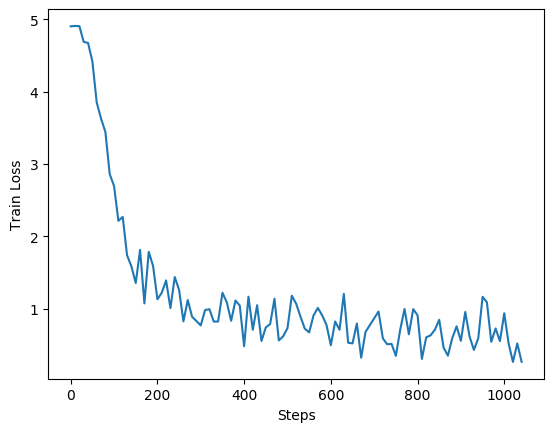

In [16]:
import matplotlib.pyplot as plt
from smdebug.trials import create_trial

path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(path)

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.show()

In [16]:
from IPython.display import HTML
import requests

url = 'https://profiler-2023.s3.amazonaws.com/profiler-report+(4).html'
html_content = requests.get(url).content.decode('utf-8')

display(HTML(html_content))



**1**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

Yes, there was some anomalous behavior in my debugging output. For example, when I obtained the output of the hyperparameters, the numerical values were passed as strings, which caused errors when I tried to execute the code again. Additionally, I encountered multiple errors until I wrote the code correctly, and it eventually became fully functional. For instance, in the first part, I was fixated on passing a parameter to the net function to avoid having to look up the number of classes, making it automatic. However, in the main part, I had to adjust the functions until it worked. I realized later that I should have created the dataset first and then passed the parameter to the net function. Overall, there was some disorganization that I had to correct.

**2**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

A possible error might look like this:

```
Traceback (most recent call last):
  File "train_model.py", line 285, in <module>
    main(args)
  File "train_model.py", line 248, in main
    model = net(train_data_loader)
UnboundLocalError: local variable 'train_data_loader' referenced before assignment

```
This error indicates that the variable train_data_loader is referenced before it is assigned a value, likely due to some misplacement of code or incorrect variable scope. To fix this, I would need to ensure that the train_data_loader variable is correctly assigned before using it in the net function.

Another possible error could be related to tensor types, such as:

```
RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same".

```

This error indicates that I am trying to perform operations between tensors on the CPU (torch.FloatTensor) and tensors on the GPU (torch.cuda.FloatTensor). To resolve this issue, I need to make sure that the data is sent to the GPU before performing any operations with it. This can be achieved by using the .to() method to move tensors to the GPU.


## Model Deploying

In [17]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-406658208551/pytorch-training-2023-07-23-16-26-05-652/output/model.tar.gz'

In [47]:
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "ImagePredictor.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.4xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-406658208551/pytorch-training-2023-07-23-16-26-05-652/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-406658208551/pytorch-inference-2023-07-23-17-57-16-204/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-23-17-57-25-537
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-23-17-57-26-245
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-23-17-57-26-245


----!

Display Image class 10:


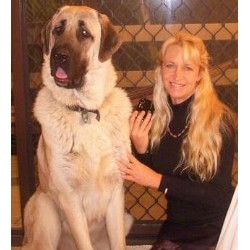

Predicción para la imagen: 10


In [45]:
import numpy as np

test_image_path = "./dogImages/test/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00661.jpg"

with open(test_image_path, "rb") as f:
    payload = f.read()
    print("Display Image class 10:")
    display(Image.open(io.BytesIO(payload)))

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
predicted_dog_breed = np.argmax(response, 1) + 1

print(f"Predicción para la imagen: {predicted_dog_breed}")

In [48]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-07-23-17-57-26-245
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-07-23-17-57-26-245
